In [96]:
from collections import defaultdict
from functools import partial, reduce
from pathlib import Path

import astropy.constants as constants
import astropy.units as u
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoLocator, AutoMinorLocator
import numpy as np
import pandas as pd
from specutils import SpectralRegion, Spectrum
from specutils.analysis import correlation
from specutils.fitting import find_lines_derivative
from specutils.manipulation import box_smooth, extract_region

from astropaul.database import database_connection
import astropaul.html as html
import astropaul.lbt as lbt
import astropaul.phase as ph
import astropaul.targetlistcreator as tlc

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
html_dir = "../../Observing Files/RV Study"
phase_event_defs = [
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.0)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.05)),
    ph.PhaseEventDef("R", partial(ph.calc_time_of_phase, phase=0.18)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.32)),
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.45)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.55)),
    ph.PhaseEventDef("R", partial(ph.calc_time_of_phase, phase=0.68)),
    ph.PhaseEventDef("B", partial(ph.calc_time_of_phase, phase=0.82)),
    ph.PhaseEventDef("T", partial(ph.calc_time_of_phase, phase=0.95)),
]

with database_connection() as conn:
    name = "RV Study"
    creator = tlc.TargetListCreator(name=name, connection=conn, phase_event_defs=phase_event_defs)
    creator.steps = [
        tlc.add_targets,
        # partial(tlc.filter_targets, criteria=lambda df: df["Target Name"] == "TIC 283940788"),
        # partial(tlc.filter_targets, criteria=lambda df: df["Target Type"] == "RV Standard"),
        partial(tlc.add_database_table, table_name="ephemerides"),
        partial(tlc.add_database_table, table_name="pepsi_observations"),
        partial(tlc.filter_targets, criteria=lambda df: df["Num PEPSI Observations"] > 0),
        tlc.ancillary_data_from_tess,
        partial(tlc.add_columns_from_sql, table_name="rv_calibration_targets", primary_cols=["RV"]),
        tlc.add_tess_catalog_associations,
        tlc.add_lists,
        partial(tlc.add_database_table, table_name="dssi_observations"),
        partial(tlc.add_database_table, table_name="speckle_detections"),
        tlc.add_pepsi_evaluations,
        tlc.add_rv_status,
        partial(tlc.add_member_phases, table_name="DSSI Observations", time_column="Mid JD"),
        partial(tlc.add_member_phases, table_name="PEPSI Observations", time_column="Mid JD"),
    ]
    tl = creator.calculate(verbose=False)
    html.render_observing_pages(tl, None, {}, html_dir)
    

In [3]:
from astropy.io import fits

hdul = fits.open("../../Files/PEPSI Spectra/202412/pepsir.20241222.002.dxt.bwl")
# hdul = fits.open("../../Files/PEPSI Spectra/202510/pepsib.20251018.030.dxt.bwl")
header = hdul[0].header
data = hdul[1].data

hdul[0].header
data

FITS_rec([(7355.74984058, 0.99575839, 8.32744717e-06, 0),
          (7355.82617838, 0.9932704 , 8.31585895e-06, 0),
          (7355.90249536, 1.00481351, 8.41489903e-06, 0), ...,
          (9069.7453297 , 0.95221779, 6.00529223e-05, 0),
          (9069.81251864, 0.96946637, 6.07642533e-05, 0),
          (9069.87968701, 0.98332774, 6.11003527e-05, 0)],
         dtype=(numpy.record, [('Arg', '>f8'), ('Fun', '>f8'), ('Var', '>f8'), ('Mask', 'i1')]))

shifted pepsib.20251018.030.dxt.bwl by 9.09 km / s on top of 12704.613 m / s.  Final RV: 12.704613 km / s
shifted pepsir.20251018.020.dxt.bwl by 9.09 km / s on top of 12704.613 m / s.  Final RV: 12.704613 km / s
shifted pepsib.20241222.007.dxt.bwl by 14.864 km / s on top of -12714.407 m / s.  Final RV: -12.714407 km / s
shifted pepsir.20241222.003.dxt.bwl by 14.864 km / s on top of -12714.407 m / s.  Final RV: -12.714407 km / s
shifted pepsib.20250408.068.dxt.bwl by 4.455 km / s on top of 10091.54 m / s.  Final RV: 10.091540000000002 km / s
shifted pepsir.20250408.056.dxt.bwl by 4.455 km / s on top of 10091.54 m / s.  Final RV: 10.091540000000002 km / s
shifted pepsib.20241223.011.dxt.bwl by -9.0 km / s on top of 17419.1 m / s.  Final RV: 17.4191 km / s
shifted pepsir.20241223.007.dxt.bwl by -9.0 km / s on top of 17419.099 m / s.  Final RV: 17.419099 km / s
shifted pepsib.20241222.006.dxt.bwl by 11.66 km / s on top of -10352.483 m / s.  Final RV: -10.352483000000001 km / s
shifted peps

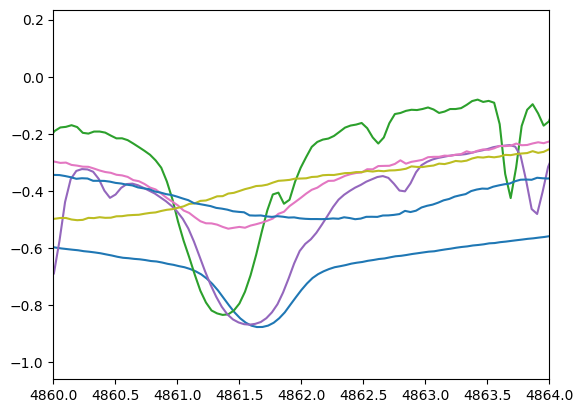

In [4]:
spectra_by_file = {
    path.name: lbt.read_pepsi_file(path)
    for path in list(Path("../../Files/PEPSI Spectra/").glob("20*/*.bwl"))
    + list(Path("../../Files/PEPSI Spectra/").glob("20*/*.nor"))
}

# do additional spectrum shift for targets with known radial velocity
rv_standards = {
    target_name: rv * u.km / u.s
    for target_name, rv in tl.target_list[tl.target_list["RV"] == tl.target_list["RV"]][["Target Name", "RV"]].to_numpy()
}
observations = tl.other_lists["PEPSI Observations"]
import astropy.constants as constants

_, ax = plt.subplots()
for target_name, rv in rv_standards.items():
    for spectrum_file in observations[observations["Target Name"] == target_name]["Spectrum File"]:
        rv_spectrum = spectra_by_file[spectrum_file]
        observer_to_barycenter_rv = rv_spectrum.meta["Barycenter RV"]
        # total_rv = rv + observer_to_barycenter_rv + rv * observer_to_barycenter_rv / constants.c
        # rv_spectrum.shift_spectrum_to(radial_velocity=total_rv)
        post = rv_spectrum.radial_velocity
        rv_spectrum.meta["RV from catalog"] = rv
        print(f"shifted {spectrum_file} by {rv} on top of {observer_to_barycenter_rv}.  Final RV: {rv_spectrum.radial_velocity}")
        ax.plot(rv_spectrum.spectral_axis, rv_spectrum.flux)
ax.set_xlim(4860, 4864)
plt.show()

In [5]:
# base_dir = "../../Files/PEPSI Spectra/"

# blue_spectra = [
#     # (lbt.PepsiSpectrum.read(base_dir + "202310/pepsib.20231102.043.dxt.bwl"), (.33, .75, .25)),
#     (lbt.PepsiSpectrum.read(base_dir + "202409/pepsib.20240920.072.dxt.bwl"), (.31, .83, .32)),
#     (lbt.PepsiSpectrum.read(base_dir + "202412/pepsib.20241222.004.dxt.bwl"), (.83, .71, .21)),
#     (lbt.PepsiSpectrum.read(base_dir + "202412/pepsib.20241223.027.dxt.bwl"), (.93, .18, .68)),
#     (lbt.PepsiSpectrum.read(base_dir + "202412/pepsib.20241224.025.dxt.bwl"), (.12, .68, .17)),
# ]

# red_spectra = [
#     (lbt.PepsiSpectrum.read(base_dir + "202310/pepsir.20231102.045.dxt.bwl"), (.33, .75, .25)),
#     (lbt.PepsiSpectrum.read(base_dir + "202409/pepsir.20240920.015.dxt.bwl"), (.31, .83, .32)),
#     (lbt.PepsiSpectrum.read(base_dir + "202412/pepsir.20241222.000.dxt.bwl"), (.83, .71, .21)),
#     (lbt.PepsiSpectrum.read(base_dir + "202412/pepsir.20241223.023.dxt.bwl"), (.93, .18, .68)),
#     (lbt.PepsiSpectrum.read(base_dir + "202412/pepsir.20241224.021.dxt.bwl"), (.12, .68, .17)),
# ]

# hd38979b = lbt.PepsiSpectrum.read(base_dir + "202412/pepsib.20241222.006.dxt.bwl", radial_velocity=11.66 * u.km / u.s)
# hd38979r = lbt.PepsiSpectrum.read(base_dir + "202412/pepsir.20241222.002.dxt.bwl", radial_velocity=11.66 * u.km / u.s)
# hip104548b = lbt.PepsiSpectrum.read(base_dir + "202412/pepsib.20241223.011.dxt.bwl", radial_velocity=-9 * u.km / u.s)
# hip104548r = lbt.PepsiSpectrum.read(base_dir + "202412/pepsir.20241223.007.dxt.bwl", radial_velocity=-9 * u.km / u.s)
# hip112051b = lbt.PepsiSpectrum.read(base_dir + "202510/pepsib.20251018.030.dxt.bwl", radial_velocity=9.09 * u.km / u.s)
# hip112051r = lbt.PepsiSpectrum.read(base_dir + "202510/pepsir.20251018.020.dxt.bwl", radial_velocity=9.09 * u.km / u.s)

In [6]:
def smooth_spectrum(spectrum, width):
    smoothed_spectrum = box_smooth(spectrum, width=width)
    smoothed_spectrum.meta["Smoothing"] = width
    return smoothed_spectrum

def make_plot(plot_name, spectra, template, do_correlation=True, linewidth=0.5, jd_offset=2460000):
    if do_correlation:
        fig = plt.figure(figsize=(11, 8.5), layout="constrained")
        gs = GridSpec(2, 2, figure=fig)
        ax_sig = fig.add_subplot(gs[0, :])
        ax_auto = fig.add_subplot(gs[1, 0])
        ax_temp = fig.add_subplot(gs[1, 1])
    else:
        fig, ax_sig = plt.subplots(figsize=(11, 8.5))
    prior_highest = -np.min(template.flux) # highest y value of previous plot, to prevent overlap of traces
    y_offset = np.max(template.flux) - np.min(template.flux) # add this to get the plot to sit above its predecessor
    for spectrum in spectra:
        this_lowest = np.min(spectrum.flux)
        y_offset = prior_highest - this_lowest
        ax_sig.plot(
            spectrum.spectral_axis,
            spectrum.flux + y_offset,
            label=f"{spectrum.meta['Observation Time'].iso[:10]} {spectrum.meta['Phase List']}",
            # label=f"{spectrum.meta['Observation Time'].jd - jd_offset:.5f} {spectrum.meta['Phase List']}",
            linewidth=linewidth,
        )
        prior_highest = np.max(spectrum.flux + y_offset)
        if do_correlation:
            auto_corr, auto_lag = correlation.template_correlate(spectrum, spectrum)
            ax_auto.plot(auto_lag, auto_corr, linewidth=linewidth)
            corr, lag = correlation.template_correlate(spectrum, template)
            ax_temp.plot(lag, corr, linewidth=linewidth)
    if do_correlation:
        ax_sig.plot(template.spectral_axis, template.flux - np.min(template.flux), label=template.meta["Target Name"], linewidth=linewidth)
    ax_sig.set_title(plot_name)
    ax_sig.set_xlabel(r"Wavelength, ($\AA$)")
    ax_sig.xaxis.set_major_locator(MaxNLocator(nbins=9, prune=None))
    ax_sig.xaxis.set_minor_locator(AutoMinorLocator(n=10))
    ax_sig.set_ylabel("Flux (au)")
    ax_sig.legend(title=f"JD - {jd_offset}", loc="lower right")
    ax_sig.margins(y=0.15)
    scale = 2 / (spectra[0].spectral_axis[0] + spectra[0].spectral_axis[-1]) * constants.c
    ax_sig.text(0.05, 0.005, f"1 $\\AA$ = {scale.value:.0f} km/s at plot center", ha="left", va="bottom", transform=ax_sig.transAxes)
    ax_sig.grid(axis="x", color="0.70", which="major")
    ax_sig.grid(axis="x", color="0.95", which="minor")

    if do_correlation:
        ax_auto.set_title("Auto Correlation")
        ax_auto.set_xlim(0, 500)
        ax_auto.xaxis.set_major_locator(MaxNLocator(prune=None))
        ax_auto.xaxis.set_minor_locator(AutoLocator())
        ax_auto.set_xlabel("Velocity (km/s)")
        ax_auto.grid(axis="x", color="0.70", which="major")
        ax_auto.grid(axis="x", color="0.95", which="minor")

        ax_temp.set_title(f"Correlation to {template.meta["Target Name"]}")
        ax_temp.set_xlim(-500, 500)
        ax_temp.xaxis.set_major_locator(MaxNLocator(nbins=9, prune=None))
        ax_temp.xaxis.set_minor_locator(AutoMinorLocator(n=10))
        ax_temp.set_xlabel("Velocity (km/s)")
        ax_temp.grid(axis="x", color="0.70", which="major")
        ax_temp.grid(axis="x", color="0.95", which="minor")
    return fig

In [7]:
lines = {
    2: [4341, 4481.5],
    3: [4861, 4934, 4957, 5018.5, 5183.5, 5227, 5317, 5383],
    5: [6563],
    6: [7462, 7495, 7511, 7555.5, 7896, 7999, 8046, 8446.5, 8498, 8542, 8662, 8807, 8912, 8927],
}

half_width = 20
feature_regions = []
for cd, line_list in lines.items():
    for i, line in enumerate(line_list):
        feature_regions.append((f"CD{cd} Feature {i}", cd, (line - half_width, line + half_width)))
feature_regions

[('CD2 Feature 0', 2, (4321, 4361)),
 ('CD2 Feature 1', 2, (4461.5, 4501.5)),
 ('CD3 Feature 0', 3, (4841, 4881)),
 ('CD3 Feature 1', 3, (4914, 4954)),
 ('CD3 Feature 2', 3, (4937, 4977)),
 ('CD3 Feature 3', 3, (4998.5, 5038.5)),
 ('CD3 Feature 4', 3, (5163.5, 5203.5)),
 ('CD3 Feature 5', 3, (5207, 5247)),
 ('CD3 Feature 6', 3, (5297, 5337)),
 ('CD3 Feature 7', 3, (5363, 5403)),
 ('CD5 Feature 0', 5, (6543, 6583)),
 ('CD6 Feature 0', 6, (7442, 7482)),
 ('CD6 Feature 1', 6, (7475, 7515)),
 ('CD6 Feature 2', 6, (7491, 7531)),
 ('CD6 Feature 3', 6, (7535.5, 7575.5)),
 ('CD6 Feature 4', 6, (7876, 7916)),
 ('CD6 Feature 5', 6, (7979, 8019)),
 ('CD6 Feature 6', 6, (8026, 8066)),
 ('CD6 Feature 7', 6, (8426.5, 8466.5)),
 ('CD6 Feature 8', 6, (8478, 8518)),
 ('CD6 Feature 9', 6, (8522, 8562)),
 ('CD6 Feature 10', 6, (8642, 8682)),
 ('CD6 Feature 11', 6, (8787, 8827)),
 ('CD6 Feature 12', 6, (8892, 8932)),
 ('CD6 Feature 13', 6, (8907, 8947))]

In [8]:
templates = {
    2: Spectrum(np.ones(5000) * u.dimensionless_unscaled, np.linspace(4265, 4800, 5000) * u.AA),
    # 3: smooth_spectrum(spectra_by_file["pepsib.20241222.006.dxt.bwl"], 9),
    # 3: spectra_by_file["pepsib.20241223.011.dxt.bwl"],
    3: spectra_by_file["pepsib.20241223.011.dxt.bwl"],
    5: Spectrum(np.ones(5000) * u.dimensionless_unscaled, np.linspace(6278, 7419, 5000) * u.AA),
    6: smooth_spectrum(spectra_by_file["pepsir.20241222.002.dxt.bwl"], 9),
    # 6: spectra_by_file["pepsir.20241223.007.dxt.bwl"]
}

templates[2].meta["Target Name"] = "Flat Line" 
# templates[2].meta[""] =

smoothing_factors = {0: 15, 1: 50, 2: 25, 3: 15, 4: 9, 5: 5} # cross disperser: width

regions = [  # name, cross disperser, (lo, hi)
    # ("Steve 1", 6, (7767, 7787)),
    # ("Steve 2", 6, (8532, 8556)),
    # ("Steve 2 wide", 6, (8502, 8586)),
    # ("Steve 3", 6, (8655, 8675)),
    # ("Balmer n=4 to 2", 3, (4831, 4891)),
    # ("Balmer n=5 to 2", 2, (4320, 4362)),
    # ("Pfund n=6 to 5", 6, (7440, 7500)),
    # ("CD2", 2, (4265, 4800)),
    # ("CD3", 3, (4800, 5441)),
    # ("CD5", 5, (6278, 7419)),
    # ("CD6", 6, (7419, 9067)),
    ("Mg II", 2, (4465, 4500)),
    ("Blue Mid", 3, (4990, 5070)),
    # # ("Blue Mid Tight", 3, (5025, 5065)),
    # # ("Blue Zoom", 3, (5010, 5025)),
    # ("Blue asd", 3, (5300, 5360)),
    ("Hbeta Wide", 3, (4840, 4885)),
    # ("Oxygen 777", 6, (7754, 7797)),
    # ("Paschen", 6, (8500, 8900)),
    # ("Paschen Narrow 1", 6, (8520, 8570)),
    # from wikipedia on hydrogen lines
    # ("Balmer n=3 to 2", 5, (6533, 6593)),
    ("Balmer n=4 to 2", 3, (4831, 4891)),
    # ("Balmer n=5 to 2", 2, (4320, 4360)),
    # ("Paschen n=inf to 3", 6, (8184, 8224)),
    ("Pfund n=6 to 5", 6, (7440, 7500)),
    ("Pfund n=7 to 5", 2, (4634, 4674)),
    #
    # ("CD2 Section 1", 2, (4265, 4465)),
    # ("CD2 Section 2", 2, (4465, 4665)),
    # ("CD2 Section 3", 2, (4665, 4800)),
    # ("CD3 Section 1", 3, (4800, 5000)),
    # ("CD3 Section 2", 3, (5000, 5200)),
    # ("CD3 Section 3", 3, (5200, 5400)),
    # ("CD3 Section 4", 3, (5400, 5441)),
    # ("CD5 Section 1", 5, (6278, 6478)),
    # ("CD5 Section 2", 5, (6478, 6678)),
    # ("CD5 Section 3", 5, (6678, 6878)),
    # ("CD5 Section 4", 5, (6878, 7078)),
    # ("CD5 Section 5", 5, (7078, 7278)),
    # ("CD5 Section 6", 5, (7278, 7419)),
    # ("CD6 Section 1", 6, (7419, 7585)),
    # ("CD6 Section 2", 6, (7619, 7819)),
    # ("CD6 Section 3", 6, (7819, 8019)),
    # ("CD6 Section 4", 6, (8019, 8219)),
    # ("CD6 Section 5", 6, (8219, 8419)),
    # ("CD6 Section 6", 6, (8419, 8619)),
    # ("CD6 Section 7", 6, (8619, 8819)),
    # ("CD6 Section 8", 6, (8819, 9019)),
    # ("CD6 Section 9", 6, (9019, 9067)),
    #
]
regions = feature_regions

science_targets = set(tl.target_list[tl.target_list["Target Type"].isin(["QuadEB", "SextEB"])]["Target Name"])
science_targets = {"TIC 307119043"}
# science_targets = {"TIC 278352276"}
# science_targets = {"TIC 25818450"}
# science_targets = {
#     "TIC 278352276",
#     "TIC 307119043",
#     "TIC 322727163",
#     "TIC 336882813",
#     "TIC 367448265",
#     "TIC 454140642",
#     "TIC 52856877",
# }

figures = []
for region_name, cross_disperser, (region_lo, region_hi) in regions:
    # with PdfPages(f"plots/{region_name}.pdf") as pdf:
        criteria = (
            (observations["Evaluation"] > 0)
            & (observations["Target Name"].isin(science_targets))
            & (observations["Cross Disperser"].str[0] == str(cross_disperser))
        )
        matching_observations = observations[criteria]
        if len(matching_observations) == 0:
            continue
        region = SpectralRegion(region_lo * u.AA, region_hi * u.AA)
        template = extract_region(templates[cross_disperser], region)
        for target_name, group in matching_observations.groupby("Target Name"):
            smooth_spectra = []
            for filename, phase_list, evaluation in group.sort_values("Mid JD")[["Spectrum File", "Member Phases", "Evaluation"]].to_numpy():
                spectrum = extract_region(spectra_by_file[filename], region)
                if spectrum.shape == (0,):
                    continue
                spectrum.meta["Phase List"] = phase_list
                smooth_spectra.append(smooth_spectrum(spectrum, smoothing_factors[evaluation]))
            plot_name = f"{region_name} - {target_name}"
            print(plot_name)
            fig = make_plot(plot_name, smooth_spectra, template, False)
            # pdf.savefig(fig)
            # fig.savefig(f"plots/{plot_name}.png")
            figures.append(fig)
            # plt.show()
            plt.close()

with PdfPages(f"plots/{list(science_targets)[0]} Features.pdf") as pdf:
    for figure in figures:
        pdf.savefig(figure)

CD2 Feature 0 - TIC 307119043
CD2 Feature 1 - TIC 307119043
CD3 Feature 0 - TIC 307119043
CD3 Feature 1 - TIC 307119043
CD3 Feature 2 - TIC 307119043
CD3 Feature 3 - TIC 307119043
CD3 Feature 4 - TIC 307119043
CD3 Feature 5 - TIC 307119043
CD3 Feature 6 - TIC 307119043
CD3 Feature 7 - TIC 307119043
CD5 Feature 0 - TIC 307119043
CD6 Feature 0 - TIC 307119043
CD6 Feature 1 - TIC 307119043
CD6 Feature 2 - TIC 307119043
CD6 Feature 3 - TIC 307119043
CD6 Feature 4 - TIC 307119043
CD6 Feature 5 - TIC 307119043
CD6 Feature 6 - TIC 307119043
CD6 Feature 7 - TIC 307119043
CD6 Feature 8 - TIC 307119043
CD6 Feature 9 - TIC 307119043
CD6 Feature 10 - TIC 307119043
CD6 Feature 11 - TIC 307119043
CD6 Feature 12 - TIC 307119043
CD6 Feature 13 - TIC 307119043


Red Mid
* prominent double peaks, with T|R pattern: 3922
* possible 4 peak structure with T|T pattern: 2581
* boring as hell, single lines for all epochs: 4707

Hbeta Wide
* Double line in some, single in others: 3071

Oxygen 777
* Several emission lines consistent across targets, eg 2839
* Some targets have no emission lines but large central structure: 3922, 5285

Paschen
* Single lines that meander across epochs: 3277, 1230
* Single lines that don't meander much: 3368
* Very sharp single lines: 2046
* Some double, some single peaks: 2783, 3071

Pfund
* Many epochs with lots of structure variation: 2783, 3071, 3368, 

Steve 2 wide
* Many epochs with lots of structure variation: 2783, 3071, 3227, 3368, 4541?

Balmer n=4
* 3674, 5285

Pfund
* 2783, 3071, 3368

Interesting lines in 3071
* CD2: 4332, 4481, 4550
* CD3: 4871, 4922, 4962, 5018, 5185, 5227, 5317, 5383
* CD5: 6562
* CD6: 7462, 7495, 7510, 7560, 7877, 7897, 8000, 8045, 8447, 8497, 8542, 8662, 8807, 8912, 8927



If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


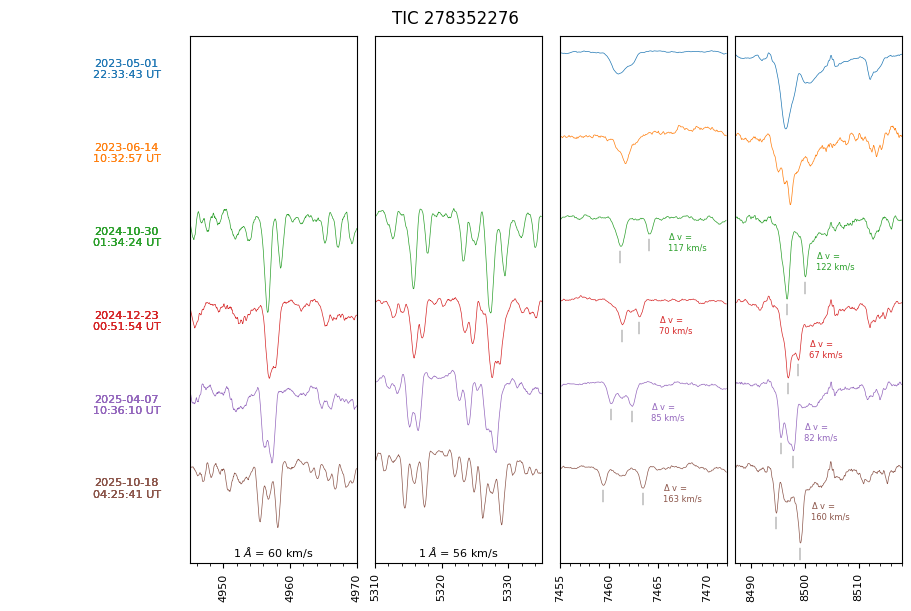

In [130]:
smoothing_factors = {0: 15, 1: 50, 2: 25, 3: 15, 4: 9, 5: 9}  # cross disperser: width

sub_plot_regions = [
    # 2: [(4461.5, 4501.5)],
    (3, SpectralRegion(4945 * u.AA, 4970 * u.AA), float("nan")),
    (3, SpectralRegion(5310 * u.AA, 5335 * u.AA), float("nan")),
    (6, SpectralRegion(7455 * u.AA, 7472 * u.AA), 0.035),
    # (6, SpectralRegion(7442 * u.AA, 7472 * u.AA), float("nan")),
    (6, SpectralRegion(8487 * u.AA, 8518 * u.AA), 0.1),
]

plot_separation = 0.25
target_to_plot = "TIC 278352276"

fig, axs = plt.subplots(1, len(sub_plot_regions) + 1, figsize=(9,6), sharey=True, constrained_layout=True)
axs[0].set_ylim(-0.02, 1.55)
axs[0].spines["top"].set_color("None")
axs[0].spines["left"].set_color("None")
axs[0].spines["right"].set_color("None")
axs[0].spines["bottom"].set_color("None")
axs[0].set_xticks([])
for ax in axs[1:]:  # [1:-1]:
    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis="x", rotation=90, labelsize=8)
    ax.set_yticks([])

for i, (_, region, line_threshold) in enumerate(sub_plot_regions):
    lo, hi = region.lower.value, region.upper.value
    axs[i + 1].set_xlim(lo, hi)
    if line_threshold != line_threshold:
        scale = 2 / (lo + hi) * constants.c.to(u.Unit("km/s"))
        axs[i + 1].text((lo + hi) / 2, 0.00, f"1 $\\AA$ = {scale.value:.0f} km/s", ha="center", size=8)

plot_observations = observations[observations["Target Name"] == target_to_plot].sort_values("Mid JD")
epochs = list(plot_observations["Date UTC"].unique())
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colors_by_epoch = {epoch: colors[i % len(colors)] for i, epoch in enumerate(epochs)}
times_by_epoch = plot_observations.groupby("Date UTC")["Exposure Start UTC"].first().str[:-4].to_dict()
for filename, cd_str, date, evaluation in plot_observations[
    ["Spectrum File", "Cross Disperser", "Date UTC", "Evaluation"]
].to_numpy():
    cd_obs = int(cd_str[0])
    for i, (cd_reg, region, line_threshold) in enumerate(sub_plot_regions):
        if cd_obs != cd_reg:
            continue
        index = epochs.index(date)
        offset = (len(epochs) - index) * plot_separation
        axs[0].text(
            0.7,
            offset - plot_separation * 0.3,
            f"{date}\n{times_by_epoch[date]} UT",
            color=colors_by_epoch[date],
            ha="center",
            size=8,
        )
        spectrum = extract_region(spectra_by_file[filename], region)
        spectrum = smooth_spectrum(spectrum, smoothing_factors[evaluation])
        axs[i + 1].plot(spectrum.spectral_axis, spectrum.flux + offset, linewidth=0.5, color=colors_by_epoch[date])
        if line_threshold != line_threshold:
            continue
        lines = find_lines_derivative(spectrum, flux_threshold=line_threshold)
        if len(lines) == 2:
            for line_center, line_center_index in lines["line_center", "line_center_index"]:
                y = spectrum.flux[line_center_index]
                axs[i + 1].plot(
                    [line_center.value, line_center.value],
                    [y + offset - 0.05, y + offset - 0.015],
                    color="black",
                    linewidth=0.3,
                )
            a, b = lines["line_center"]
            rv_sep = (2 * (b - a) / (b + a) * constants.c).to(u.Unit("km/s"))
            axs[i + 1].text(
                b.value + 2,
                spectrum.flux[lines[1][2] + 50].value + offset - 0.1,
                f"$\\Delta$ v = \n{rv_sep.value:.0f} km/s",
                color=colors_by_epoch[date],
                size=6,
            )
fig.suptitle(target_to_plot, ha="center")
plt.show()
fig.savefig("NSF Proposal spectra.png")